## PSF size from adaptive moments: trace radius and determinant radius 

### Following:  LSST DM Stack Image Quality Walkthrough 

https://github.com/LSSTScienceCollaborations/StackClub/blob/a08df1992e5100fdc01d88f3f5a979e5b96841c3/Validation/image_quality_demo.ipynb


In [1]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
import itertools
%matplotlib inline

# Rubin TAP service utilities
import lsst.geom as geom
import lsst.afw.display as afwDisplay  # for image visualization
import lsst.afw.table as afwTable
from lsst.daf.butler import Butler # access to LSST data products
import lsst.daf.base as dafBase
afwDisplay.setDefaultBackend('matplotlib')
from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius

import warnings
from astropy.units import UnitsWarning
warnings.simplefilter("ignore", category=UnitsWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
repo = 's3://butler-us-central1-dp01'
collection = '2.2i/runs/DP0.1'
butler = Butler(repo, collections=collection)

In [3]:
def PSF_diagnostics(visit, detector, band): 
    dataId={'band':band,'visit':visit,'detector':detector}  
    calexp = butler.get('calexp', **dataId)
    src = butler.get('src', **dataId)

    psf = calexp.getPsf()
    shape = psf.computeShape()
    x_array = np.arange(0, calexp.getDimensions()[0]+1, 200)
    y_array = np.arange(0, calexp.getDimensions()[1]+1, 200)
    xx, yy = np.meshgrid(x_array, y_array)

    size = [] # trace radius
    det_radius = []
    i_xx, i_yy, i_xy = [] , [] , []
    for x, y in zip(xx.flatten(), yy.flatten()):
        point = geom.Point2D(x, y)
        shape = psf.computeShape(point)
        size.append(shape.getTraceRadius())
        det_radius.append(shape.getDeterminantRadius()) 
        i_xx.append(shape.getIxx())
        i_yy.append(shape.getIyy())
        i_xy.append(shape.getIxy())
    size = np.reshape(size, xx.shape)
    i_xx = np.reshape(i_xx, xx.shape)
    i_yy = np.reshape(i_yy, xx.shape)
    i_xy = np.reshape(i_xy, xx.shape)
    det_radius = np.reshape(det_radius, xx.shape)
    dif_rad = np.abs(size - det_radius)

    size = size[:-1, :-1]
    det_radius = det_radius[:-1, :-1]
    dif_rad = dif_rad[:-1, :-1]

    e1 = (i_xx - i_yy) / (i_xx + i_yy)
    e2 = (2. * i_xy) / (i_xx + i_yy)
    e = np.sqrt(e1**2 + e2**2)
    theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
    ex = e * np.cos(theta)
    ey = e * np.sin(theta)
    e_grid = e[:-1, :-1]

    def ellipticity_radii(i_xx, i_yy, i_xy):
        theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
        e1 = (i_xx - i_yy) / (i_xx + i_yy)
        e2 = (2. * i_xy) / (i_xx + i_yy)
        e = np.sqrt(e1**2 + e2**2)
        TraceRad = np.sqrt((i_xx + i_yy) / 2.)
        DetRad = (i_xx * i_yy - i_xy**2)**(1. / 4.)
        return TraceRad, DetRad, e

    def comparison_src_psf(sample):
        output = []
        for i in range(len(sample)):
            point = sample[i].getCentroid()
            shape_psf = psf.computeShape(point)
            i_xx_psf = sample[i]['base_SdssShape_psf_xx']#shape_psf.getIxx()
            i_yy_psf = sample[i]['base_SdssShape_psf_yy']#shape_psf.getIyy()
            i_xy_psf = sample[i]['base_SdssShape_psf_xy']#shape_psf.getIxy()
            TraceRad_psf, DetRad_psf, e_psf = ellipticity_radii(i_xx_psf, i_yy_psf, i_xy_psf)#shape_psf.getTraceRadius()
            #DetRad_psf = shape_psf.getDeterminantRadius()

            i_xx_src = sample[i]['base_SdssShape_xx']
            i_yy_src = sample[i]['base_SdssShape_yy']
            i_xy_src = sample[i]['base_SdssShape_xy']
            e_src = ellipticity_radii(i_xx_src, i_yy_src, i_xy_src)[2]
            TraceRad_src , DetRad_src , e_src= ellipticity_radii(i_xx_src, i_yy_src, i_xy_src)
            #DetRad_src = ellipticity_radii(i_xx_src, i_yy_src, i_xy_src)[1]
            x_point = point[0]
            y_point = point[1]
    
            output.append([x_point, y_point, TraceRad_psf, DetRad_psf, e_psf, TraceRad_src, DetRad_src, e_src])

        return np.asarray(output)

    psf_used = src[src['calib_psf_used'] == True]
    psf_reserved = src[src['calib_psf_reserved'] == True]

    used = comparison_src_psf(psf_used)
    reserved = comparison_src_psf(psf_reserved)

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    #############  CALEXP  #############
    plt.sca(ax[0,0])  
    display1 = afwDisplay.Display(frame=fig)
    display1.scale('linear', 'zscale')
    display1.mtv(calexp.image)
    display1.show_colorbar(False)
    plt.text(150, 150, band +" band", color = 'y', fontsize=20)
    plt.text(150, 3700, "visit "+ str(visit) + "   detector " + str(detector), color = 'orange', fontsize=18)
    for s in psf_used:
        plt.plot(s.getX(), s.getY(), 'o', ms=6, mew=1.5, mfc = 'None', mec = 'b')
    for s2 in psf_reserved:
        plt.plot(s2.getX(), s2.getY(), '^', ms=7, mfc = 'None', mew=1.5, mec = 'lime')

    #############  TRACE RADIUS  #############
    plt.sca(ax[0,1])
    plt.pcolormesh(xx, yy, size, cmap='cool', shading='flat')
    colorbar = plt.colorbar(label='Trace Radius [pix]')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Size')

    # x_point, y_point, TraceRad_psf, DetRad_psf, e_psf, TraceRad_src, DetRad_src, e_src
    x_used = used[:,0]
    y_used = used[:,1]
    TraceRad_used = used[:,5]
    plt.rcParams['scatter.edgecolors'] = "k"
    plt.scatter(x_used, y_used, c=TraceRad_used, s=80, vmin=np.min(size), vmax=np.max(size), cmap='cool')

    x_reserved = reserved[:,0]
    y_reserved = reserved[:,1]
    TraceRad_reserved = reserved[:,5]
    plt.rcParams['scatter.edgecolors'] = "lime"
    plt.scatter(x_reserved, y_reserved, c=TraceRad_reserved, marker='^', s=80, vmin=np.min(size), vmax=np.max(size), cmap='cool')

    #############  ELLIP STICKS  #############
    plt.sca(ax[1,0])
    plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.01, cmap='plasma')
    colorbar = plt.colorbar(label='e')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Ellipticity Sticks')

    ############# ELLIPTICITY  #############
    plt.sca(ax[1,1])
    plt.pcolormesh(xx, yy, e_grid, cmap='plasma', shading='flat')
    colorbar = plt.colorbar(label='e')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Ellipticity');
    # x_point, y_point, TraceRad_psf, DetRad_psf, e_psf, TraceRad_src, DetRad_src, e_src
    e_used = used[:,7]
    plt.rcParams['scatter.edgecolors'] = "k"
    plt.scatter(x_used, y_used, c=e_used, s=80, vmin=np.min(e_grid), vmax=np.max(e_grid), cmap='plasma')

    e_reserved = reserved[:,7]
    plt.rcParams['scatter.edgecolors'] = "lime"
    plt.scatter(x_reserved, y_reserved, c=e_reserved, marker='^', s=80, vmin=np.min(e_grid), vmax=np.max(e_grid), cmap='plasma');

In [4]:
def plot_PSFresiduals(visit, detector, band):
    dataId = {'visit': visit, 'detector': detector, 'band': band}
    calexp = butler.get('calexp', dataId = dataId)
    src = butler.get('src', dataId)
    psf_used = src[src['calib_psf_used'] == True]
    psf_reserved = src[src['calib_psf_reserved'] == True]
    residuals = calexp.maskedImage.getImage()
    psf = calexp.getPsf()
    
    def plot_residuals(stars_type, ncol):
    
        if stars_type == 'reserved': 
            stars_t = psf_reserved
            title = r'Stars reserved to test PSF '
            color_title = 'lime'
        else: 
            stars_t = psf_used
            title = r'Stars used for PSF '
            color_title = 'k'

        nrow = int(len(stars_t)/ncol)
        f, ax = plt.subplots(ncols=ncol, nrows=nrow, sharex=False, sharey=False, figsize=(10, 10*(nrow/6)))

        i=0
        for r in range(nrow):
            for c in range(ncol):
                psfImage = psf.computeImage(stars_t[i].getCentroid()).convertF()
                psfImage *= stars_t[i].getPsfInstFlux()/np.sum(psfImage.getArray())
                flux = psfImage.getArray() - residuals[psfImage.getBBox()].getArray()
                ax[r,c].imshow(flux, origin='lower', cmap = 'Greys', vmin=-150, vmax=130)
                ax[r,c].set_axis_off()
                i = i + 1
        plt.title(title, color=color_title, fontsize=20, x=-1.5, y=nrow*1.04)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.01,hspace=0.01);

    plot_residuals('reserved', 6)
    plot_residuals('used', 6)
    

To test different visits and detectors

159494, 23

185783, 47

260, 43

400357, 80

637849, 186


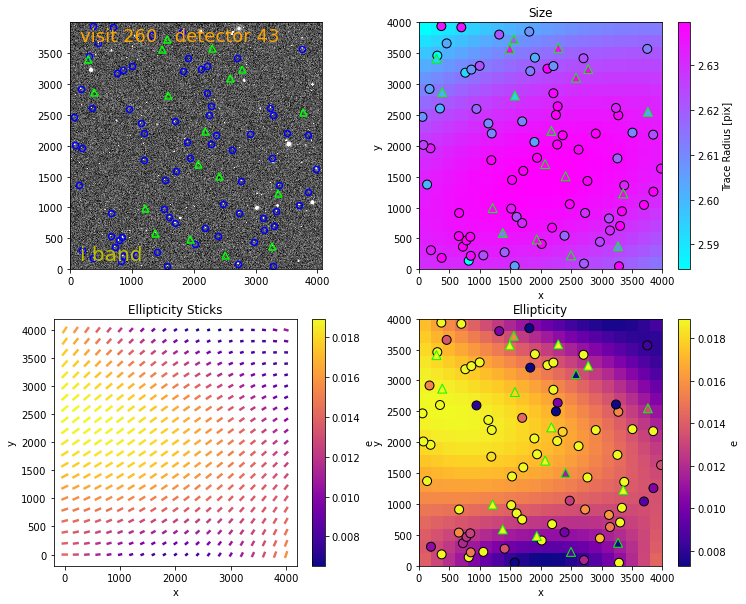

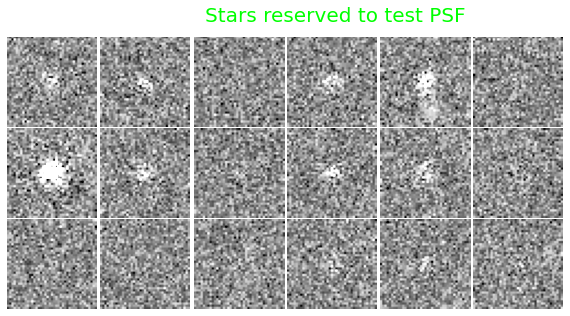

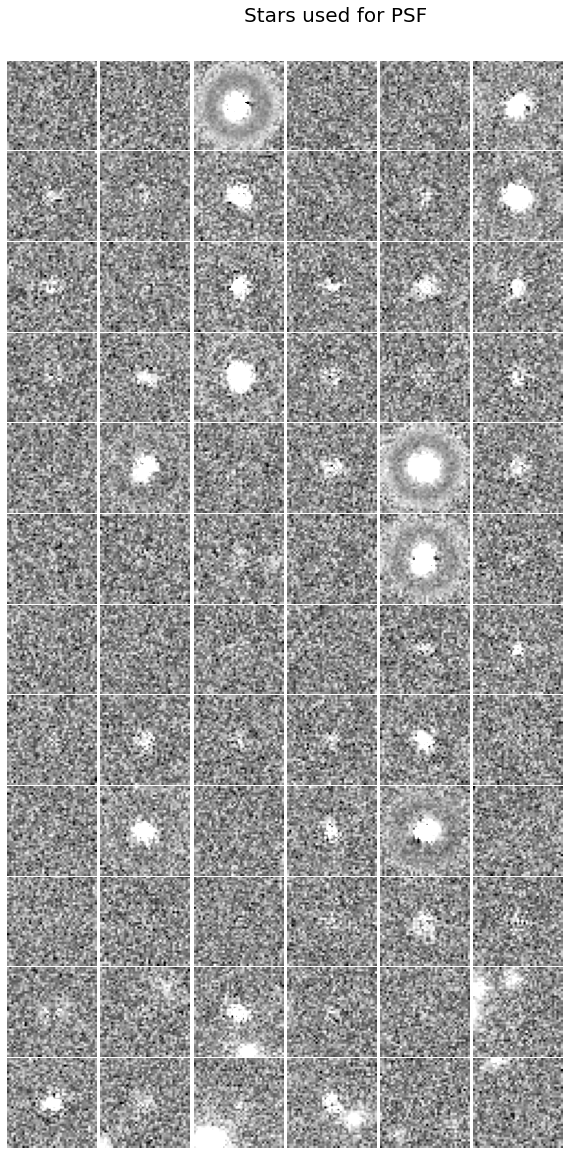

In [7]:
PSF_diagnostics(260, 43, 'i')
plot_PSFresiduals(260, 43, 'i')

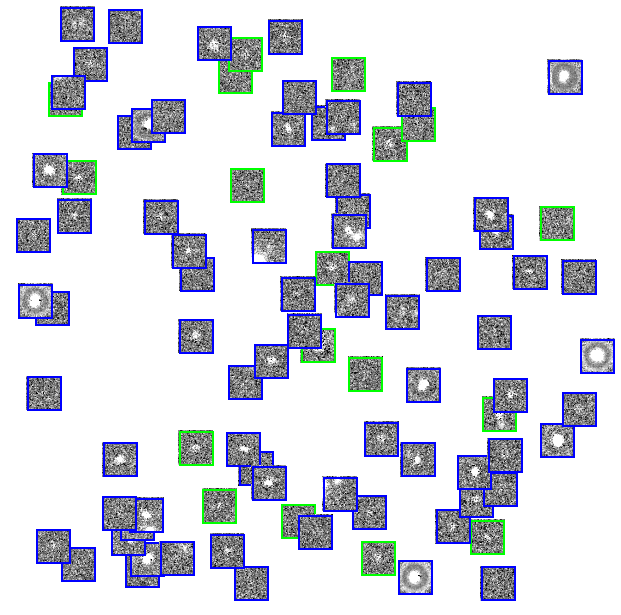

In [8]:
xdataId={'band':'g','visit':260,'detector':43}  
xcalexp = butler.get('calexp', **xdataId)
xsrc = butler.get('src', **xdataId)

psf_used = xsrc[xsrc['calib_psf_used'] == True]
psf_reserved = xsrc[xsrc['calib_psf_reserved'] == True]
residuals = xcalexp.maskedImage.getImage()
psf = xcalexp.getPsf()

fig, ax = plt.subplots(frameon=False, figsize=(8,8))
ax = plt.Axes(fig, [0., 0., 1., 1.]) 
plt.axis('off')

for i in range(len(psf_reserved)):
    x_psfStar = psf_reserved[i]['base_SdssCentroid_x']/xcalexp.getDimensions()[0]
    y_psfStar = psf_reserved[i]['base_SdssCentroid_y']/xcalexp.getDimensions()[1]
    ax2 = fig.add_axes([x_psfStar, y_psfStar, 0.06, 0.06])
    psfImage = psf.computeImage(psf_reserved[i].getCentroid()).convertF()
    psfImage *= psf_reserved[i].getPsfInstFlux()/np.sum(psfImage.getArray())
    flux = psfImage.getArray() - residuals[psfImage.getBBox()].getArray()
    ax2.plot(20, 20, 's', mec='lime', mew=2, mfc='None', ms=33)
    ax2.imshow(flux, origin='lower', cmap = 'Greys', vmin=-120, vmax=80)
    ax2.set_axis_off()

for i in range(len(psf_used)):
    x_psfStar = psf_used[i]['base_SdssCentroid_x']/4000
    y_psfStar = psf_used[i]['base_SdssCentroid_y']/4000
    ax2 = fig.add_axes([x_psfStar, y_psfStar, 0.06, 0.06])
    psfImage = psf.computeImage(psf_used[i].getCentroid()).convertF()
    psfImage *= psf_used[i].getPsfInstFlux()/np.sum(psfImage.getArray())
    flux = psfImage.getArray() - residuals[psfImage.getBBox()].getArray()
    ax2.plot(20, 20, 's', mec='b', mew=2, mfc='None', ms=33)
    ax2.imshow(flux, origin='lower', cmap = 'Greys', vmin=-120, vmax=80)
    ax2.set_axis_off()


plt.subplots_adjust(left=0., right=1, bottom=0, top=1.)